In [1]:
from pathlib import Path
import sys

CWD = Path.cwd()

if (CWD / "src").exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / "src").exists():
    PROJECT_ROOT = CWD.parent
else:
    raise RuntimeError("Cannot locate project root")

sys.path.insert(0, str(PROJECT_ROOT))

FIGURES_DIR = PROJECT_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Figures dir:", FIGURES_DIR)


Project root: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml
Figures dir: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\figures


In [2]:
from src.utils import load_dataset
from src.datasets import encode_target, select_base_features
from src.features import add_irregularity_index

df = load_dataset("data/breast_cancer_wisconsin.csv")
df = encode_target(df)
df = select_base_features(df)
df_feat = add_irregularity_index(df)

df_feat.head()


,concavity_mean,perimeter_mean,radius_mean,area_mean,target,irregularity_index
0,0.3001,122.80,17.99,1001.0,1,0.000020
1,0.0869,132.90,20.57,1326.0,1,0.000005
2,0.1974,130.00,19.69,1203.0,1,0.000012
3,0.2414,77.58,11.42,386.1,1,0.000040
4,0.1980,135.10,20.29,1297.0,1,0.000011


In [3]:
from sklearn.model_selection import train_test_split
from src.models import get_logistic_model

X = df_feat[
    [
        "concavity_mean",
        "perimeter_mean",
        "radius_mean",
        "area_mean",
        "irregularity_index",
    ]
]
y = df_feat["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

model = get_logistic_model(class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [4]:
import pandas as pd

results = X_test.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred

# Focus on false negatives (most dangerous)
false_negatives = results[
    (results["y_true"] == 1) & (results["y_pred"] == 0)
]

true_positives = results[
    (results["y_true"] == 1) & (results["y_pred"] == 1)
]

print("False negatives:", len(false_negatives))
print("True positives:", len(true_positives))


False negatives: 11
True positives: 53


In [5]:
results["size_bucket"] = pd.qcut(
    results["perimeter_mean"],
    q=3,
    labels=["Small", "Medium", "Large"]
)

results["size_bucket"].value_counts()


size_bucket
Small     57
Medium    57
Large     57
Name: count, dtype: int64

In [6]:
failure_rates = (
    results[results["y_true"] == 1]
    .groupby("size_bucket")
    .apply(lambda x: ((x["y_pred"] == 0).sum()) / len(x))
)

failure_rates


C:\Users\sprin\AppData\Local\Temp\ipykernel_4136\3692762499.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("size_bucket")
C:\Users\sprin\AppData\Local\Temp\ipykernel_4136\3692762499.py:4: RuntimeWarning: invalid value encountered in scalar divide
  .apply(lambda x: ((x["y_pred"] == 0).sum()) / len(x))
C:\Users\sprin\AppData\Local\Temp\ipykernel_4136\3692762499.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: ((x["y_pred"] == 0).sum()) / len(x))


size_bucket
Small          NaN
Medium    0.666667
Large     0.020408
dtype: float64

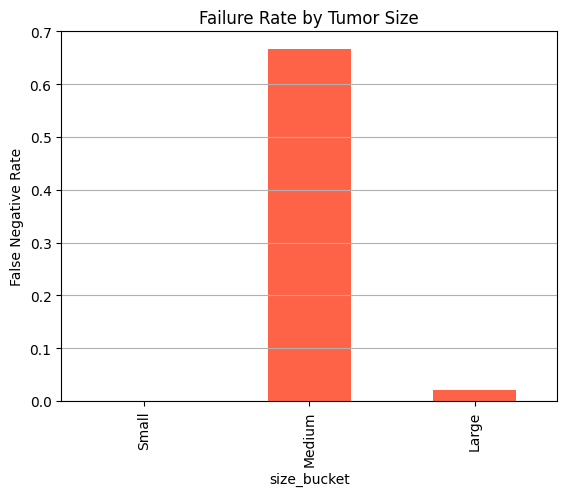

In [7]:
import matplotlib.pyplot as plt

failure_rates.plot(kind="bar", color="tomato")
plt.ylabel("False Negative Rate")
plt.title("Failure Rate by Tumor Size")
plt.grid(axis="y")

plt.savefig(
    FIGURES_DIR / "h3_failure_rate_by_size.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


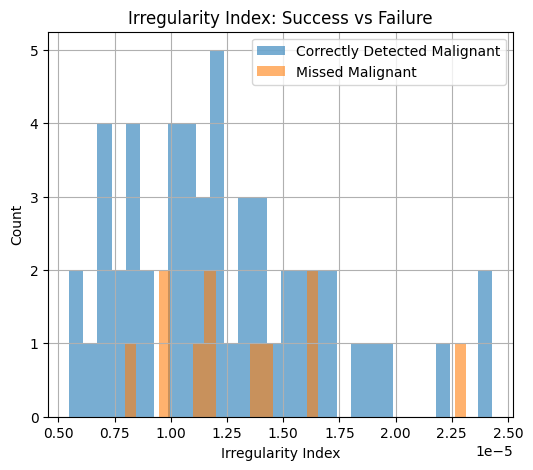

In [8]:
plt.figure(figsize=(6, 5))

plt.hist(
    true_positives["irregularity_index"],
    bins=30,
    alpha=0.6,
    label="Correctly Detected Malignant",
)

plt.hist(
    false_negatives["irregularity_index"],
    bins=30,
    alpha=0.6,
    label="Missed Malignant",
)

plt.xlabel("Irregularity Index")
plt.ylabel("Count")
plt.title("Irregularity Index: Success vs Failure")
plt.legend()
plt.grid(True)

plt.savefig(
    FIGURES_DIR / "h3_irregularity_failure_distribution.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


CWD: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\notebooks
Saving to: C:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\figures
Saved file exists: True
Saved at: c:\Users\sprin\OneDrive\Desktop\breast_ cancer_ml\figures\h3_decision_tree.png


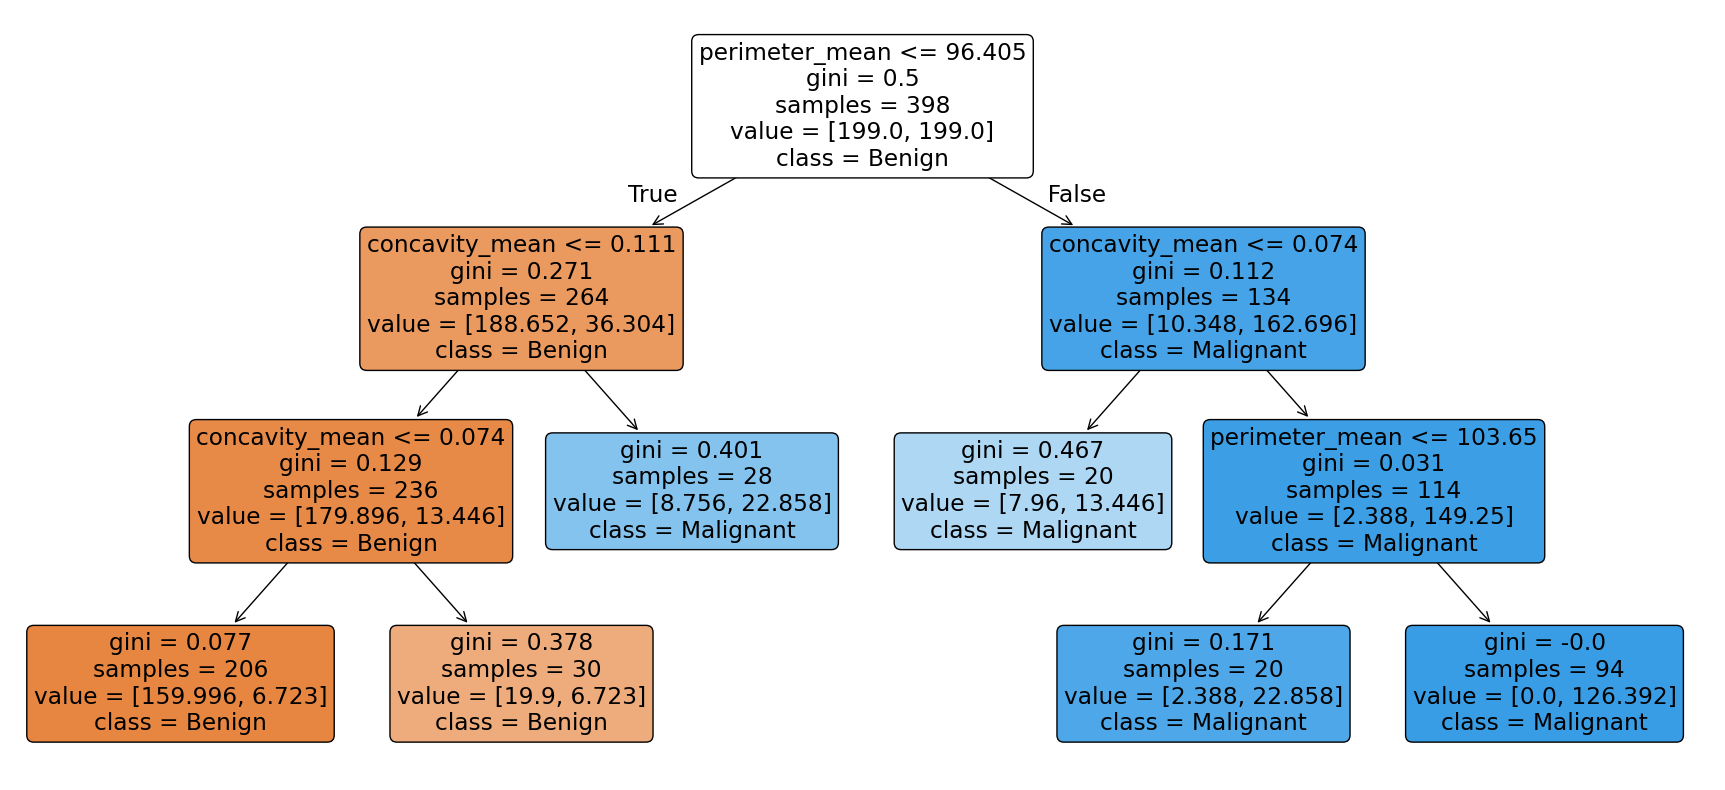

In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from pathlib import Path
import os

# --- DEBUG: confirm where we are ---
print("CWD:", os.getcwd())

# --- Absolute path to figures directory ---
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
FIGURES_DIR = PROJECT_ROOT / "figures"
FIGURES_DIR.mkdir(exist_ok=True)

print("Saving to:", FIGURES_DIR.resolve())

# --- Train decision tree ---
tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=42
)
tree.fit(X_train, y_train)

# --- Create and SAVE figure ---
fig, ax = plt.subplots(figsize=(22, 10))
plot_tree(
    tree,
    feature_names=X_train.columns,
    class_names=["Benign", "Malignant"],
    filled=True,
    rounded=True,
    ax=ax
)

output_path = FIGURES_DIR / "h3_decision_tree.png"
fig.savefig(output_path, dpi=300, bbox_inches="tight")

print("Saved file exists:", output_path.exists())
print("Saved at:", output_path)

plt.show()
plt.close(fig)
